<h1><center> The Boolean pandemic </center></h1>

<hr>


* [1. Dataset description](#description)
* [2. The needed steps](#needs)
    * [2.1. Import Libraries](#import)
    * [2.2. Import datasets](#import2)
* [3. Data Understanding](#understand) 
    * [3.1. Check datasets](#datasets)
* [4. Data Preparation](#preparation) 
    * [4.1. Data Cleaning](#cleaning)
    * [4.2. Feature Engineering](#feature)
    * [4.3. Outliers](#outliers)
    * [4.4. Data Distribution](#distribution) 
* [5. Further Analysis](#further) 
* [6. Feature Selection](#feature) 
* [7. Models](#model) 
    * [7.1. MLPClassifier](#model_1)
    * [7.2. ExtraTreesClassifier](#model_2)
    * [7.3. Bagging Classifier with ExtraTreesClassifier](#model_3)


<hr>
<a id="description">
    
# 1. Dataset description
    
</a>
<br>


- **Patient_ID:** The unique identifier of the patient;
- **Family_Case_ID:** The family identification;
- **Severity:** The severity of the disease, where 1 is the lowest and 3 the highest severity;
- **Name:** The name of the patient;
- **Birthday_year:** The year of birthday of the patient;
- **Parents_Siblings_Infected:** The number of parents and/or siblings infected;
- **Partner_Children_Infected:** The number of partner and/or children infected;
- **Medical_Expenses_Family:** The medical expenses associated to try to contain the epidemy on the family;
- **Medical_Tent:** The medical tent where the patient is / was lodged;
- **City:** The original city of the patient;
- **Deceased:** Flag if the patient deceased or not with the virus (0 = No, 1 = Yes).

<hr>
<a id="needs">
    
# 2. The needed steps
    
</a>

<a  id="import">

## 2.1. Import Libraries

</a>



In [5]:
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import requests, zipfile, io
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from scipy.stats import norm
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier 

<a id="import2">

## 2.2. Import Dataset
</a>

In [6]:
r = requests.get('https://github.com//SofiaGeraldes//ML//blob//master//Data.zip?raw=true')

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

del z
del r

test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

<hr>
<a class="anchor" id="understand">
    
# 3. Data Understanding
    
</a>



<a  id="datasets">

## 3.1. Check datasets

</a>

**Note:** There was an error with the name of two variables: 

- "Parents or siblings infected" should be "Parents or children infected";
- "Wife/Husband or children infected" should be "Wife/Husband or siblings infected".

In [7]:
train = train.rename(columns={"Parents or siblings infected": "Parents or children infected", 
                      "Wife/Husband or children infected": "Wife/Husband or siblings infected"})

test = test.rename(columns={"Parents or siblings infected": "Parents or children infected", 
                      "Wife/Husband or children infected": "Wife/Husband or siblings infected"})

**- Train set:**

In [8]:
train.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or children infected,Wife/Husband or siblings infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [9]:
train.shape

(900, 11)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Parents or children infected       900 non-null    int64  
 6   Wife/Husband or siblings infected  900 non-null    int64  
 7   Medical_Expenses_Family            900 non-null    int64  
 8   Medical_Tent                       198 non-null    object 
 9   City                               898 non-null    object 
 10  Deceased                           900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [7]:
train.describe()

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or children infected,Wife/Husband or siblings infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,450.500000,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,259.951919,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,1.000000,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,225.750000,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,450.500000,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,675.250000,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,900.000000,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


- As we can see from the table above, the minimum and maximum values of the variables 'Birthday_year' and 'Medical_Expenses_Family' are very discrepant, which may require standardization.

**- Test set:**

In [8]:
test.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or children infected,Wife/Husband or siblings infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe


In [9]:
test.shape

(400, 10)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         400 non-null    int64  
 1   Family_Case_ID                     400 non-null    int64  
 2   Severity                           400 non-null    int64  
 3   Name                               400 non-null    object 
 4   Birthday_year                      318 non-null    float64
 5   Parents or children infected       400 non-null    int64  
 6   Wife/Husband or siblings infected  400 non-null    int64  
 7   Medical_Expenses_Family            400 non-null    int64  
 8   Medical_Tent                       89 non-null     object 
 9   City                               400 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 31.4+ KB


In [11]:
test.describe() 

,Patient_ID,Family_Case_ID,Severity,Birthday_year,Parents or children infected,Wife/Husband or siblings infected,Medical_Expenses_Family
count,400.000000,400.000000,400.000000,318.000000,400.000000,400.000000,400.000000
mean,1100.500000,46024.932500,2.247500,1989.707547,0.400000,0.452500,1013.870000
std,115.614301,39279.856807,0.844409,14.171527,0.998746,0.910944,1587.588114
min,901.000000,1162.000000,1.000000,1944.000000,0.000000,0.000000,0.000000
25%,1000.750000,13487.000000,1.000000,1980.250000,0.000000,0.000000,221.000000
50%,1100.500000,26721.500000,3.000000,1993.000000,0.000000,0.000000,406.000000
75%,1200.250000,79045.000000,3.000000,1999.000000,0.000000,1.000000,883.250000
max,1300.000000,128562.000000,3.000000,2019.000000,9.000000,8.000000,14345.000000


- Again, as we can see from the table above, the minimum and maximum values of the variables 'Birthday_year' and 'Medical_Expenses_Family' are very discrepant, which may require standardization.

<hr>
<a class="anchor" id="preparation">
    
# 4. Data Preparation
    
</a>

<a  id="cleaning">

## 4.1. Data Cleaning

</a>

**- Checking missing values:**

In [12]:
train.isnull().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or children infected           0
Wife/Husband or siblings infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [13]:
test.isnull().sum()

Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                         82
Parents or children infected           0
Wife/Husband or siblings infected      0
Medical_Expenses_Family                0
Medical_Tent                         311
City                                   0
dtype: int64

- **Train:** Variable "Age" has 177 missing values, 'Medical_Tent' has 702 and 'City' only 2.

- **Test:** Variable "Age" has 82 missing values and 'Medical_Tent' has 311.

**- Treat missing values:**

- Age - Fill 'Age' missing values with the rounded mean, as integer type

In [14]:
# TRAIN:
train['Birthday_year'].fillna((train['Birthday_year'].mean()), inplace=True)
train['Birthday_year'] = train['Birthday_year'].round(0).astype(int)
# TEST:
test['Birthday_year'].fillna((test['Birthday_year'].mean()), inplace=True)
test['Birthday_year'] = test['Birthday_year'].round(0).astype(int)

- Medical_Tent - Fill 'Medical_Tent' missing values with 'N' (None)


In [15]:
# TRAIN
train.Medical_Tent = train.Medical_Tent.fillna('N')
# TEST
test.Medical_Tent = test.Medical_Tent.fillna('N')

- City - Fill 'City' missing values with the index of the first occurrence of maximum over requested axis

In [16]:
# TRAIN
train['City']= train['City'].fillna(train['City'].value_counts().idxmax())
# TEST
test['City']= test['City'].fillna(test['City'].value_counts().idxmax())

<a  id="feature">

## 4.2. Feature Engineering

</a>

**- Change Birthday_year to Age**

In [17]:
# Create a variable that will save the current date
today = datetime.today()

- TRAIN:

In [18]:
# Create a column with the Age 
train['Age'] = train['Birthday_year'].apply(lambda x: today.year - x)

# Drop the Birthday_year column
train = train.drop(columns=['Birthday_year'], axis=1)

- TEST:

In [19]:
# Create a column with the Age 
test['Age'] = test['Birthday_year'].apply(lambda x: today.year - x)

# Drop the Birthday_year column
test = test.drop(columns=['Birthday_year'], axis=1)

**- Create a variable named Sex**

- TRAIN:

In [20]:
# Split the titles from the 'Name' variable, creating another variable named 'Title'
split = (train['Name'].str.strip().str.split(' ', n=1, expand=True).rename(columns={0:'Title', 1:'Names'}))

# Join the 'Title' column to the train dataset
train = pd.concat([train, split], axis=1)

# Convert the titles to number: Miss and Ms to 1; and Mr. and Master to 0
train['Sex'] = train['Title'].map(dict(zip(['Miss','Ms.', 'Mr.', 'Master'],[1, 1, 0, 0])))

# Drop the columns 'Names', 'Title' and 'Name'
train = train.drop(columns = ['Names', 'Title', 'Name'])

- TEST:

In [21]:
# Split the titles from the 'Name' variable, creating another variable named 'Title'
split_test = (test['Name'].str.strip().str.split(' ', n=1, expand=True).rename(columns={0:'Title', 1:'Names'}))

# Join the 'Title' column to the test dataset
test = pd.concat([test, split_test], axis=1)

# Convert the titles to number: Miss and Ms to 1; and Mr. and Master to 0
test['Sex'] = test['Title'].map(dict(zip(['Miss','Mrs.', 'Mr.', 'Master'],[1, 1, 0, 0])))

# Drop the columns 'Names', 'Title' and 'Name'
test = test.drop(columns = ['Names', 'Title', 'Name'])

**- Create a variable named Family_infected** - sum of the columns 'Parents or children infected' and 'Wife/Husband or siblings infected' for each Patient


In [22]:
# TRAIN
train['Family_infected'] =  train[['Parents or children infected', 'Wife/Husband or siblings infected']].sum(axis=1)
# TEST
test['Family_infected'] =  test[['Parents or children infected', 'Wife/Husband or siblings infected']].sum(axis=1)

**- Create a variable named Total_cases** - the number of members of the family infected (maximum per Family)

In [23]:
# TRAIN
train['Total_cases'] = train['Family_infected'].groupby(train['Family_Case_ID']).transform('max')
# TEST
test['Total_cases'] = test['Family_infected'].groupby(test['Family_Case_ID']).transform('max')

**- Create a variable named Ind_Medical_Expenses** - by dividing the variable 'Medical_Expenses_Family' by the number of members of the family (by creating a variable named 'Ind_per_Family)

In [24]:
# Create the variable 'Ind_per_Family', by counting the number of individuals per family
# TRAIN
train['Ind_per_Family'] = train['Patient_ID'].groupby(train['Family_Case_ID']).transform('count')
# TEST
test['Ind_per_Family'] = test['Patient_ID'].groupby(test['Family_Case_ID']).transform('count')

# Create the variable 'Ind_Medical_Expenses'
# TRAIN
train['Ind_Medical_Expenses'] = round((train['Medical_Expenses_Family']/train['Ind_per_Family']),2)
# TEST
test['Ind_Medical_Expenses'] = round((test['Medical_Expenses_Family']/test['Ind_per_Family']),2)

**- Drop unecessary columns**

In [25]:
# TRAIN
train = train.drop(columns = ['Parents or children infected', 
                              'Wife/Husband or siblings infected', 
                              'Family_infected', 'Medical_Expenses_Family', 
                              'Ind_per_Family'], axis = 1)

# TEST
test = test.drop(columns = ['Parents or children infected', 
                            'Wife/Husband or siblings infected', 
                            'Family_infected', 'Medical_Expenses_Family', 
                            'Ind_per_Family'], axis = 1)

**- Transform categorical variables into ordinal variables, or by using LabelEncoder**

- Check the unique values of the variable City

In [26]:
train['City'].unique()

array(['Santa Fe', 'Albuquerque', 'Taos'], dtype=object)

- Associate city Santa Fe to 0, Albuquerque to 1 and Taos to 3

In [27]:
# TRAIN
train.loc[train['City'] == 'Santa Fe', 'city'] = 0
train.loc[train['City'] == 'Albuquerque', 'city'] = 1
train.loc[train['City'] == 'Taos', 'city'] = 2
# TEST
test.loc[test['City'] == 'Santa Fe', 'city'] = 0
test.loc[test['City'] == 'Albuquerque', 'city'] = 1
test.loc[test['City'] == 'Taos', 'city'] = 2

# Convert the city variable to integer
# TEST
test['city'] = test['city'].astype(int)
# TRAIN
train['city'] = train['city'].astype(int)

# Drop the City variable
# TRAIN
train = train.drop(columns = ['City'])
# TEST
test = test.drop(columns = ['City'])

- Enconde Medical_Tent variable

In [28]:
labelencoder = LabelEncoder()

# TRAIN
train['Medical_Tent'] = labelencoder.fit_transform(train['Medical_Tent'])
# TEST
test['Medical_Tent'] = labelencoder.fit_transform(test['Medical_Tent'])

<a  id="outliers">

## 4.3. Outliers

</a>

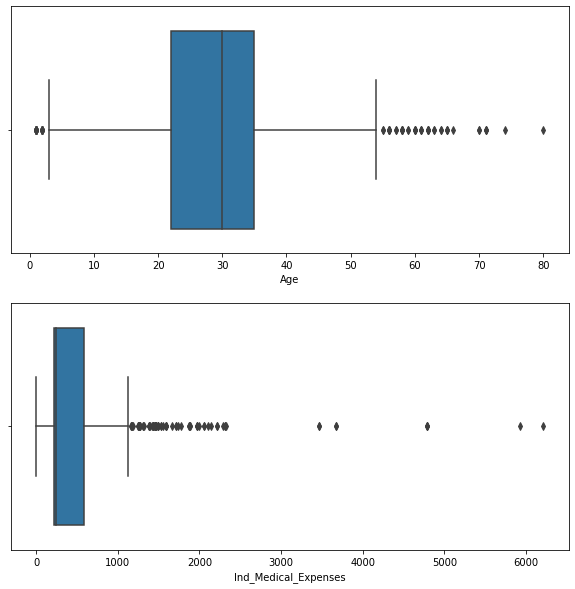

In [29]:
# Define a set of numerical variables
numeric_variables = ['Age', 'Ind_Medical_Expenses']

# Plot the boxplots for the columns previously defined 
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
for var, subplot in zip(train[numeric_variables], ax.flatten()):
    sns.boxplot(train[var], ax=subplot)  

- We attempt to delete outliers in the 'Ind_Medical_Expenses' (above 3000), but that did not end up in better model results, so we decided to keep them, after all. 

<a  id="distribution">

## 4.4. Data Distribution

</a>

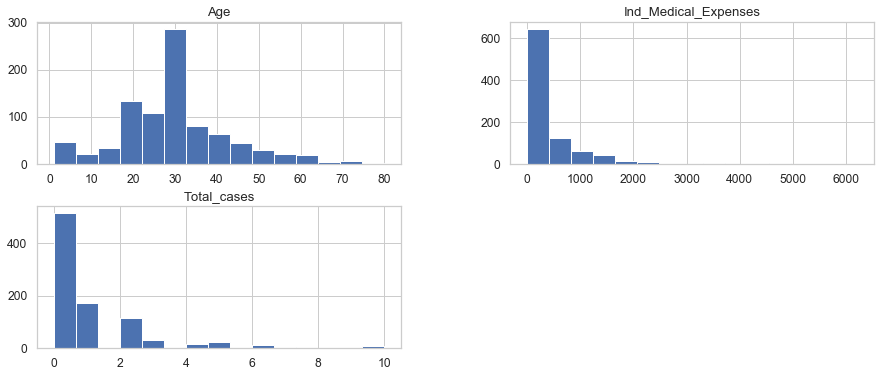

In [68]:
# Define the variables we want to see the distribution off
variables = train[['Age', 'Ind_Medical_Expenses', 'Total_cases']]

# Plot
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
variables.hist(bins=15, figsize=(15, 6), layout=(2, 2));

**- Histogram and normal probability plot**

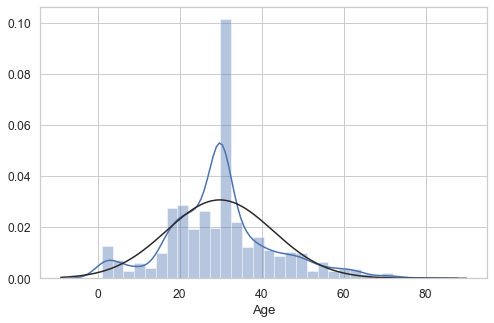

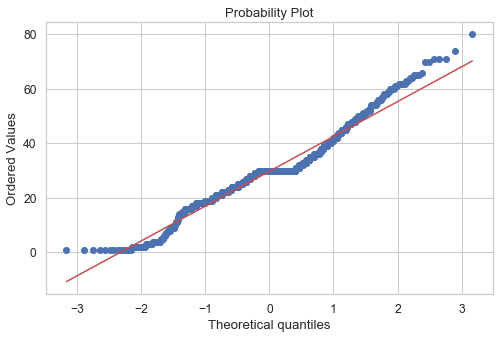

In [31]:
sns.distplot(train['Age'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['Age'], plot=plt)

- We have a young sample population, since 'Age' is skewed to right. 
- This variable does not follow a normal distribution, since it presents a positive skewness and does not follow the diagonal line.

**- Pairplot**

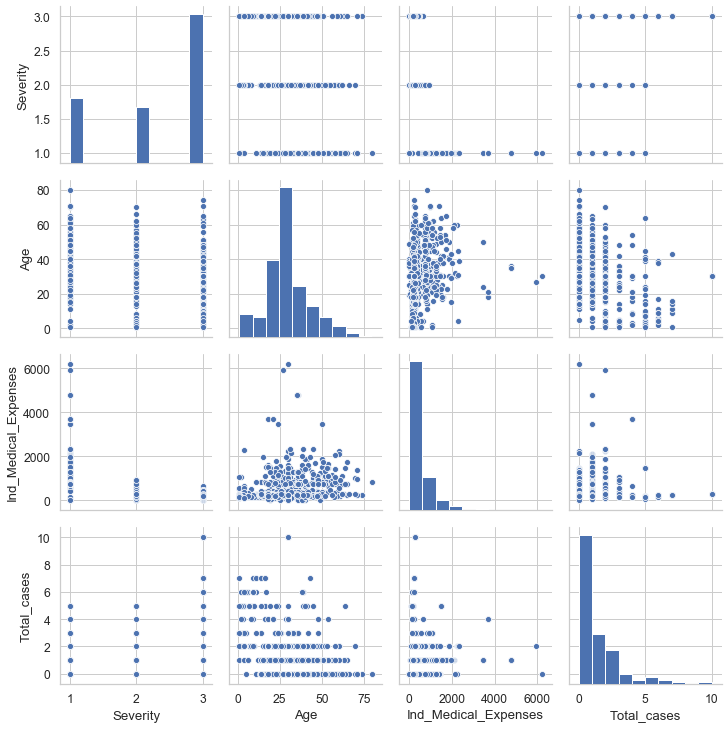

In [32]:
sns.pairplot(variables)

**- From the graph we can assess that:**

    - The most numerous infected families have severity level of 3, while the families that have never 5 or lower members infected register a severity level of 1 or 2;
    - The ones that have higher individual expenses have a disease level severity of 1. Additionally, the expenses decrease with the increase in the severity level;
    - The families with more infected members seems to have also younger individuals in the family;
    - The individuals between ages of 25 and 50 are the ones that have higher individual medical expenses;
    - The individuals that have higher individual medical expenses are the ones that have lower number of infected cases in the family.

<a  id="further">

# 5. Further Analysis

</a>

**- Check for duplicates in Patient_ID columns on train and test dataset**

In [33]:
print(test['Patient_ID'].duplicated().any(), train['Patient_ID'].duplicated().any())

False False


- There is no more than one patient with the same patient_ID

**- Check the distribution of the variable 'Decreased'**

Deceased
0    347
1    553
Name: Patient_ID, dtype: int64

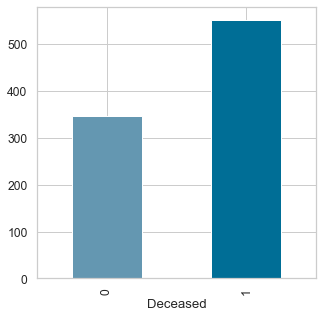

In [34]:
train_deceased = train.groupby(['Deceased'])['Patient_ID'].count()
colors = ["#6497b1", "#006e96", "#033f6c", '#63ace5']
label = ['n = 344', 'n = 553']
train_deceased.plot(kind="bar", figsize=(5,5), color=colors)
train_deceased

# 0 - Passed away
# 1 - Did not passed away

**- Check variable 'Age' distribution**

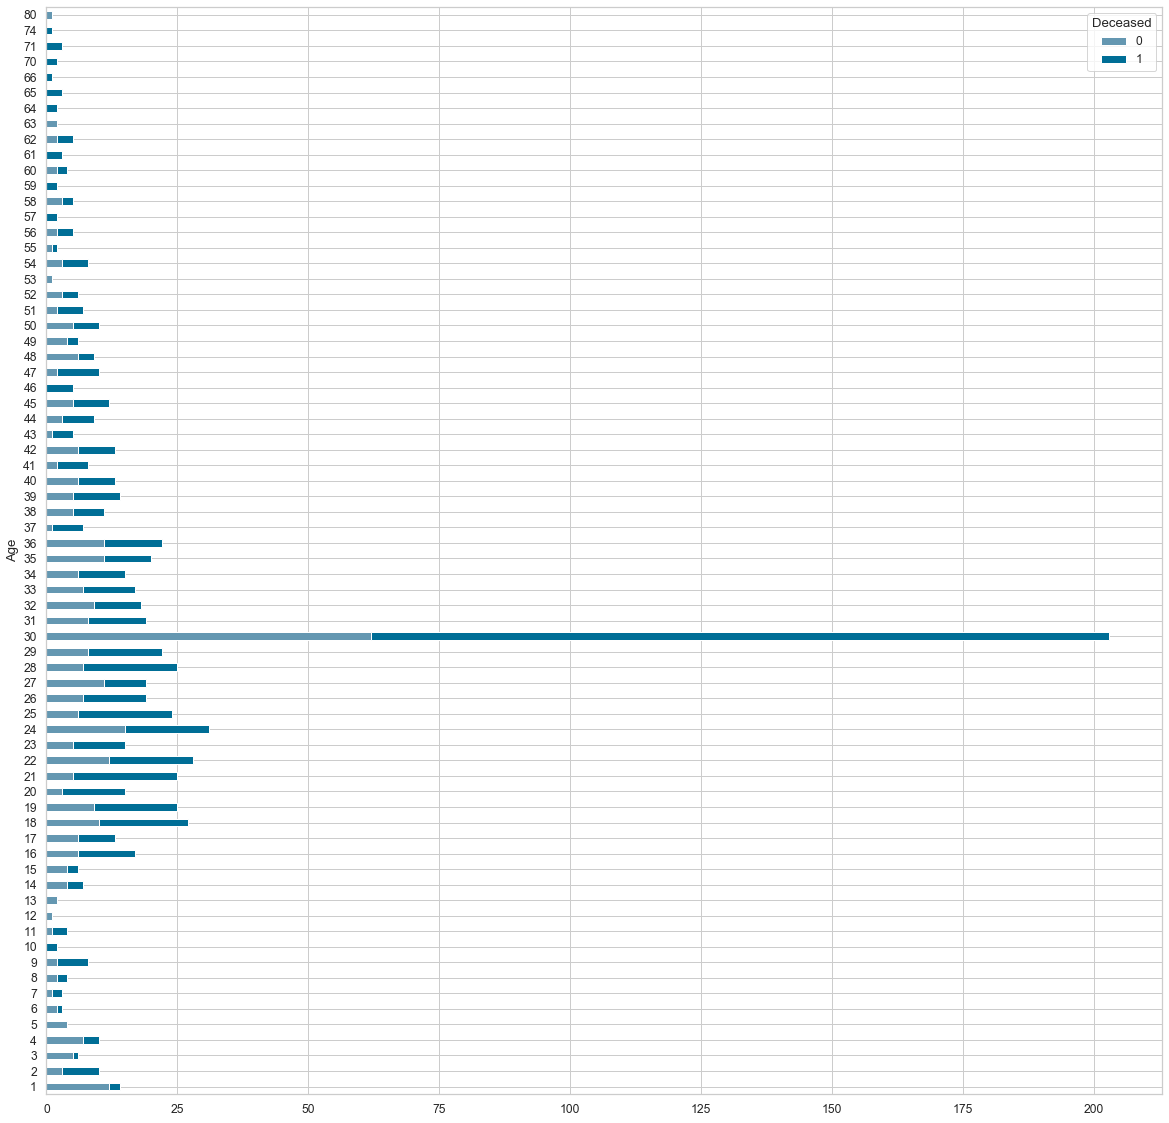

In [35]:
train_birthday = train[['Age', 'Deceased', 'Patient_ID']].drop_duplicates()
train_birthday = train_birthday.pivot_table(values='Patient_ID', columns='Deceased', index='Age', aggfunc='count')
train_birthday.iloc[:,0:2].plot.barh(stacked = True, figsize=(20,20), color=colors)

- The majority of the population is 30 years old (1990)

**- Check the variable 'Deceased' distribution based on the 'Severity'**

Deceased,0,1
Severity,,
1,136,80
2,88,98
3,123,375


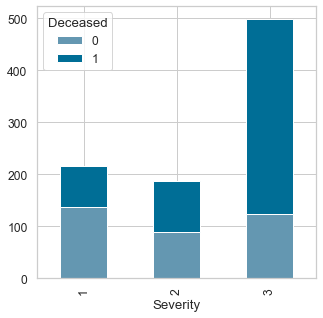

In [36]:
train_severity = train[['Severity', 'Deceased', 'Patient_ID']].drop_duplicates()
train_severity = train_severity.pivot_table(values='Patient_ID', columns='Deceased', index='Severity', aggfunc='count')
train_severity.iloc[:,0:2].plot.bar(stacked = True, figsize=(5,5), color=colors)
train_severity

# Deceased:
# 0 - Passed away
# 1 - Did not passed away

**- Check the variable 'Deceased' distribution based on the 'City'**

Deceased,0,1
city,,
0,223,428
1,94,75
2,30,50


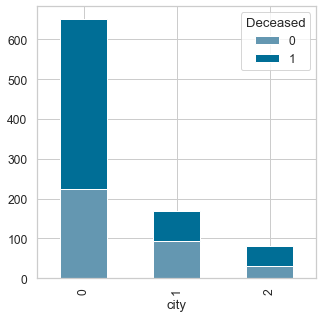

In [37]:
train_city = train[['city', 'Deceased', 'Patient_ID']].drop_duplicates()
train_city = train_city.pivot_table(values='Patient_ID', columns='Deceased', index='city', aggfunc='count')
train_city.iloc[:,0:2].plot.bar(stacked = True, figsize=(5,5), color=colors)
train_city

# Deceased:
# 0 - Passed away
# 1 - Did not passed away

**- Check the variable 'Ind_Medical_Expenses' distribution based on the 'City'**

city
0    415.161767
1    873.886627
2    250.343625
Name: Ind_Medical_Expenses, dtype: float64

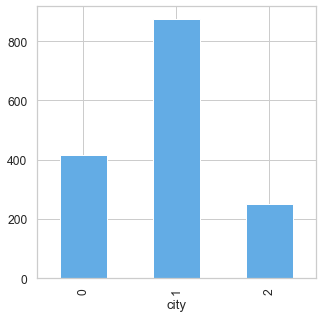

In [38]:
train_city_expenses = train.groupby(['city'])['Ind_Medical_Expenses'].mean()
train_city_expenses.plot.bar(stacked = True, figsize=(5,5), color='#63ace5')
train_city_expenses

# City:
# 0 - Santa Fe
# 1 - Albuquerque
# 2 - Taos

**- Check the variable 'Deceased' distribution based on the 'Ind_Medical_Expenses'**

Deceased
0    673.546657
1    369.374231
Name: Ind_Medical_Expenses, dtype: float64

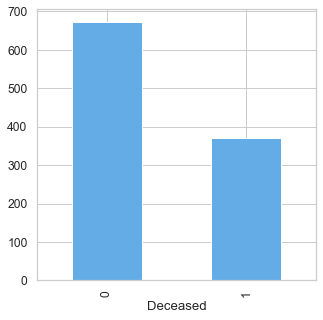

In [39]:
train_medical_expenses = train.groupby(['Deceased'])['Ind_Medical_Expenses'].mean()
train_medical_expenses.plot.bar(stacked = True, figsize=(5,5), color='#63ace5')
train_medical_expenses

# Deceased:
# 0 - Passed away
# 1 - Did not passed away

### Correlation between variables

- Set the index to become the ‘Patient_ID’ column


In [40]:
# TRAIN
train = train.set_index('Patient_ID')
# TEST
test = test.set_index('Patient_ID')

- Associate the variable Deceased to the target

In [41]:
target = train.Deceased

- Drop the columns Deceased and Family_Case_ID on the train set

In [42]:
train = train.drop(columns=['Deceased', 'Family_Case_ID'], axis=1)

- Plot the correlation matrix

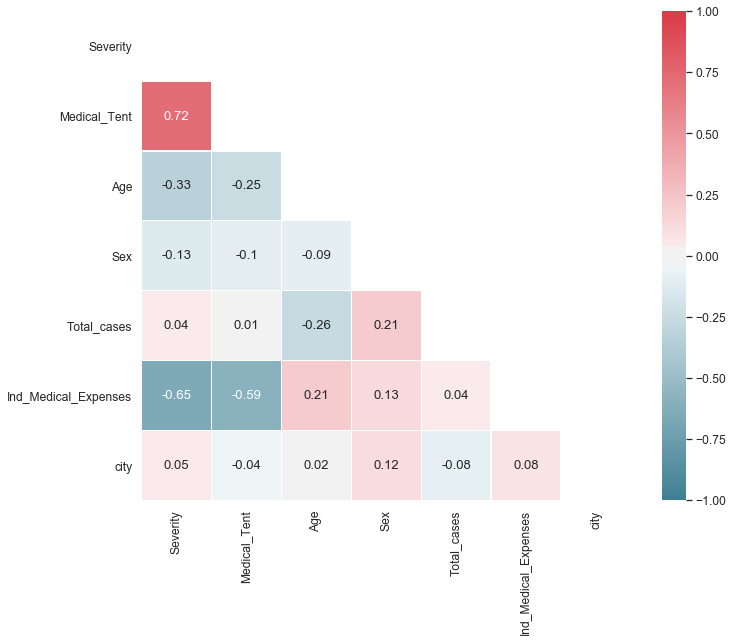

In [43]:
# Define the model to standardize the data
scaler = StandardScaler()

# Fit to data, then transform it
variables_Norm = scaler.fit_transform(train)

# Create a dataframe with the variables fitted with the columns from data 
variables_Norm = pd.DataFrame(variables_Norm, columns = train.columns)

# Compute the correlation:
correlation = variables_Norm.corr().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,square=True, linewidths=.5, annot=True)

- The variable Medical_Tent has high correlation with Severity. They probably share the same information, but since they share a correlation lower than 80% we will keep both of them.

<hr>
<a id="feature">
    
# 6. Feature Selection: RFE
    
</a>

**- Check the shape of our data**

In [44]:
train.shape

(900, 7)

- We went from 11 columns to 7 columns

**- Check the score of the estimator by chosing between 1 to 7 variables.**

- We will use RandomForest to perform Feature Selection. Feature selection using Random forest comes under the category of Wrapper methods.

In [45]:
# Number of features
nof_list=np.arange(1,7)            
high_score=0

# Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.3, random_state = 15)
    model = RandomForestClassifier()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 6
Score with 6 features: 0.833333


- From the above calculation we decided to mantain 6 variables.

**- Check which variables we should use**

In [46]:
model_rfe = RandomForestClassifier()
rfe = RFE(estimator = model_rfe, n_features_to_select = 6)
X_rfe = rfe.fit_transform(X = train, y = target) 
model_rfe.fit(X = X_rfe,y = target)
selected_features = pd.Series(rfe.ranking_, index = train.columns)
selected_features.sort_values()

Severity                1
Medical_Tent            1
Age                     1
Sex                     1
Total_cases             1
Ind_Medical_Expenses    1
city                    2
dtype: int64

**- Define a set with the variables selected with RFE**

In [47]:
rfe_variables = ['Severity','Medical_Tent','Age', 'Sex','Total_cases',
                 'Ind_Medical_Expenses']

- Define a set with all the variables for one of the models

In [48]:
all_variables = ['Severity','Medical_Tent','Age', 'Sex','Total_cases',
                 'Ind_Medical_Expenses', 'city']

<hr>
<a id="model">
    
# 7. MODELS
    
</a>
<br>

## Data Preparation for the models

**- Define data and test, based on the results of RFE**

In [49]:
# Select only the rfe_variables and save them in data
data = train[rfe_variables]

# Create a copy of the test set to be used later
test_copy = test.copy()

# Select only the rfe_variables and save them in test
test = test[rfe_variables]

**- Using the method __train_test_split__, split the __data__ into __X_train__ and __X_val__, the __target__ into __y_train__ and __y_val__, and define the following arguments:**
- __test_size__ = 0.3
- __random_state__ = 15
- __shuffle__ = True
- __stratify__ = target

In [50]:
X_train, X_val, y_train, y_val = train_test_split(data, 
                                                    target, 
                                                    test_size=0.3, 
                                                    random_state=15, 
                                                    shuffle=True, 
                                                    stratify=target)

**- Create an object named min_max1 that will contain an instance of MinMaxScaler() between 0 and 1 fitted to X_train**

In [51]:
min_max = MinMaxScaler().fit(X_train)

**- Create an object named min_max2 that will contain an instance of MinMaxScaler() between -1 and 1 fitted to X_train**

In [52]:
min_max2 = MinMaxScaler(feature_range=(-1,1)).fit(X_train)

**- Create an object named scaler that will contain an instance of StandardScaler() fitted to X_train**

In [53]:
scaler = StandardScaler().fit(X_train)

**- Create an object named robust that will contain an instance of RobustScaler() fitted to X_train**

In [54]:
robust = RobustScaler().fit(X_train)

**- Before we start we will take a look on the accuracies of different classifiers, in order to see which one we should invest on**
- These models represent our baselines

In [59]:
# Initialize our classifiers
dt = DecisionTreeClassifier()
gnb = GaussianNB()
KNN = KNeighborsClassifier(n_neighbors=1)
MNB = MultinomialNB()
BNB = BernoulliNB()
LR = LogisticRegression()
SGD = SGDClassifier()
SVC = SVC()
LSVC = LinearSVC()
NSVC = NuSVC()
bg = BaggingClassifier()
random = RandomForestClassifier()
extra = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gradient = GradientBoostingClassifier()
hist = HistGradientBoostingClassifier()
xgb = XGBClassifier()
mlp = MLPClassifier()

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],voting='hard')

# Create a StratifiedKFold instance with 10 splits, to be used in cross validation and (later on GridSearch)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=15)

# Assess the performance of the different classifiers with cross validation
scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
# Fit the classifier
xgb.fit(X_train, y_train)
print("Accuracy xgb: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores2 = cross_val_score(eclf, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
eclf.fit(X_train, y_train)
print("Accuracy eclf: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

scores3 = cross_val_score(hist, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
hist.fit(X_train, y_train)
print("Accuracy hist: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std() * 2))

scores4 = cross_val_score(gradient, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
gradient.fit(X_train, y_train)
print("Accuracy gradient: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))

scores5 = cross_val_score(ada, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
ada.fit(X_train, y_train)
print("Accuracy ada: %0.2f (+/- %0.2f)" % (scores5.mean(), scores5.std() * 2))

scores6 = cross_val_score(extra, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
extra.fit(X_train, y_train)
print("Accuracy extra: %0.2f (+/- %0.2f)" % (scores6.mean(), scores6.std() * 2))

scores7 = cross_val_score(random, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
random.fit(X_train, y_train)
print("Accuracy random: %0.2f (+/- %0.2f)" % (scores7.mean(), scores7.std() * 2))

scores8 = cross_val_score(bg, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
bg.fit(X_train, y_train)
print("Accuracy bg: %0.2f (+/- %0.2f)" % (scores8.mean(), scores8.std() * 2))

scores9 = cross_val_score(dt, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
dt.fit(X_train, y_train)
print("Accuracy dt: %0.2f (+/- %0.2f)" % (scores9.mean(), scores9.std() * 2))

scores10 = cross_val_score(gnb, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
gnb.fit(X_train, y_train)
print("Accuracy gnb: %0.2f (+/- %0.2f)" % (scores10.mean(), scores10.std() * 2))

scores11 = cross_val_score(KNN, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
KNN.fit(X_train, y_train)
print("Accuracy KNN: %0.2f (+/- %0.2f)" % (scores11.mean(), scores11.std() * 2))

scores12 = cross_val_score(BNB, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
BNB.fit(X_train, y_train)
print("Accuracy BNB: %0.2f (+/- %0.2f)" % (scores12.mean(), scores12.std() * 2))

scores13 = cross_val_score(LR, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
LR.fit(X_train, y_train)
print("Accuracy LR: %0.2f (+/- %0.2f)" % (scores13.mean(), scores13.std() * 2))

scores14 = cross_val_score(SGD, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
SGD.fit(X_train, y_train)
print("Accuracy SGD: %0.2f (+/- %0.2f)" % (scores14.mean(), scores14.std() * 2))

scores15 = cross_val_score(SVC, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
SVC.fit(X_train, y_train)
print("Accuracy SVC: %0.2f (+/- %0.2f)" % (scores15.mean(), scores15.std() * 2))

scores16 = cross_val_score(LSVC, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
LSVC.fit(X_train, y_train)
print("Accuracy LSVC: %0.2f (+/- %0.2f)" % (scores16.mean(), scores16.std() * 2))

scores17 = cross_val_score(NSVC, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
NSVC.fit(X_train, y_train)
print("Accuracy NSVC: %0.2f (+/- %0.2f)" % (scores17.mean(), scores17.std() * 2))

scores18 = cross_val_score(mlp, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
mlp.fit(X_train, y_train)
print("Accuracy mlp: %0.2f (+/- %0.2f)" % (scores18.mean(), scores18.std() * 2))

Accuracy eclf: 0.82 (+/- 0.00)
Accuracy hist: 0.83 (+/- 0.00)
Accuracy gradient: 0.84 (+/- 0.00)
Accuracy ada: 0.82 (+/- 0.00)
Accuracy extra: 0.81 (+/- 0.00)
Accuracy random: 0.84 (+/- 0.00)
Accuracy bg: 0.82 (+/- 0.00)
Accuracy dt: 0.78 (+/- 0.00)
Accuracy gnb: 0.79 (+/- 0.00)
Accuracy KNN: 0.66 (+/- 0.00)
Accuracy BNB: 0.79 (+/- 0.00)
Accuracy LR: 0.80 (+/- 0.00)
Accuracy SGD: 0.59 (+/- 0.00)
Accuracy SVC: 0.70 (+/- 0.00)
Accuracy LSVC: 0.61 (+/- 0.00)
Accuracy NSVC: 0.72 (+/- 0.00)
Accuracy mlp: 0.75 (+/- 0.00)


**- Compare train and test results**

In [60]:
# Save the performance of each classifier on the train and validation set into a dataframe
raw_data = {'VotingClassifier': [accuracy_score(y_train, eclf.predict(X_train)),accuracy_score(y_val, eclf.predict(X_val))],
            'HistGradientBoostingClassifier': [accuracy_score(y_train, hist.predict(X_train)),accuracy_score(y_val, hist.predict(X_val))],
            'GradientBoostingClassifier': [accuracy_score(y_train, gradient.predict(X_train)), accuracy_score(y_val, gradient.predict(X_val))],
            'AdaBoostClassifier': [accuracy_score(y_train, ada.predict(X_train)), accuracy_score(y_val, ada.predict(X_val))],
            'ExtraTreesClassifier': [accuracy_score(y_train, extra.predict(X_train)),accuracy_score(y_val, extra.predict(X_val))],
            'RandomForestClassifier': [accuracy_score(y_train, random.predict(X_train)), accuracy_score(y_val, random.predict(X_val))],
            'BaggingClassifier': [accuracy_score(y_train, bg.predict(X_train)), accuracy_score(y_val, bg.predict(X_val))],
            'DecisionTree': [accuracy_score(y_train, dt.predict(X_train)), accuracy_score(y_val, dt.predict(X_val))],
            'GaussianNB': [accuracy_score(y_train, gnb.predict(X_train)), accuracy_score(y_val, gnb.predict(X_val))],
            'KNN': [accuracy_score(y_train, KNN.predict(X_train)), accuracy_score(y_val, KNN.predict(X_val))],
            'BNB': [ accuracy_score(y_train, BNB.predict(X_train)), accuracy_score(y_val, BNB.predict(X_val))],
            'LR': [accuracy_score(y_train, LR.predict(X_train)), accuracy_score(y_val, LR.predict(X_val))],
            'SDG': [accuracy_score(y_train, SGD.predict(X_train)), accuracy_score(y_val, SGD.predict(X_val))],
            'SVC': [accuracy_score(y_train, SVC.predict(X_train)), accuracy_score(y_val, SVC.predict(X_val))],
            'LSVC': [accuracy_score(y_train, LSVC.predict(X_train)), accuracy_score(y_val, LSVC.predict(X_val))],
            'NSVC': [accuracy_score(y_train, NSVC.predict(X_train)), accuracy_score(y_val, NSVC.predict(X_val))],
            'XGBClassifier': [accuracy_score(y_train, xgb.predict(X_train)), accuracy_score(y_val, xgb.predict(X_val))],
            'MLPClassifier': [accuracy_score(y_train, mlp.predict(X_train)), accuracy_score(y_val, mlp.predict(X_val))]}

raw = pd.DataFrame(list(raw_data.values()), index=raw_data.keys(),columns=['Train_accuracy','Test_accuracy'])

# Sort the values by the accuracy on the validation set
raw.sort_values(by=['Test_accuracy'], ascending = False)

,Train_accuracy,Test_accuracy
GradientBoostingClassifier,0.901587,0.785185
AdaBoostClassifier,0.861905,0.785185
VotingClassifier,0.855556,0.781481
BNB,0.790476,0.781481
RandomForestClassifier,0.980952,0.781481
ExtraTreesClassifier,0.980952,0.766667
HistGradientBoostingClassifier,0.950794,0.766667
LR,0.812698,0.762963
DecisionTree,0.980952,0.744444
NSVC,0.771429,0.740741


<hr>
<a id="model_1">
    
##  MLPClassifier  
</a>
<br>

- Although it did not seem to have a good score before, we came to the conclusion that it produced better results with our data.
- Below we present our best models concerning MLPClassifier with different approaches conducted by the GridSearch results and different variable combinations (we tested the performance of MLPClassifier with the rfe_variables and with the entire dataset).

## BEST MODEL
### With rfe_variables

**- Define the model MLPClassifier**

In [61]:
model = MLPClassifier()

**- Fit the data to the model and predict**

In [64]:
# Fit the model
model.fit(X_train, y_train)

# Predict labels to validation set
labels_val = model.predict(X_val)

# Check scores
model.score(X_train, y_train), model.score(X_val, y_val)

(0.7142857142857143, 0.662962962962963)

In [63]:
# Scale X_train data set
min_max_X_train = min_max.transform(X_train)

# Scale X_val data set
min_max_X_val = min_max.transform(X_val)

# Creating an object that will contain a MLPClassifier model fitted to the scaled training data
model_min_max = MLPClassifier().fit(min_max_X_train, y_train)

# Calculate the mean accuracy of the classifier
model_min_max.score(min_max_X_val, y_val)

0.774074074074074

In [65]:
# Scale X_train data set
min_max2_X_train = min_max2.transform(X_train)

# Scale X_val data set
min_max2_X_val = min_max2.transform(X_val)

# Creating an object that will contain a MLPClassifier model fitted to the scaled training data
model_min_max2 = MLPClassifier().fit(min_max2_X_train, y_train)

# Calculate the mean accuracy of the classifier
model_min_max2.score(min_max2_X_val, y_val)

0.7814814814814814

In [66]:
# Scale X_train data set
scaler_X_train = scaler.transform(X_train)

# Scale X_val data set
scaler_X_val = scaler.transform(X_val)

# Creating an object that will contain a MLPClassifier model fitted to the scaled training data
model_scaler = MLPClassifier().fit(scaler_X_train, y_train)

# Calculate the mean accuracy of the classifier
model_scaler.score(scaler_X_val, y_val)

0.7851851851851852

In [67]:
# Scale X_train data set
robust_X_train = robust.transform(X_train)

# Scale X_val data set
robust_X_val = robust.transform(X_val)

# Creating an object that will contain a MLPClassifier model fitted to the scaled training data
model_robust = MLPClassifier().fit(robust_X_train, y_train)

# Calculate the mean accuracy of the classifier
model_robust.score(robust_X_val, y_val)

0.7851851851851852

**- Hyperparameter Tuning Implementation**
    - Since the robust standardization provided a better performance, we will use robust_X_train to fit our model with the best parameters from GridSearchCV:

In [72]:
# Define a dictionary named as grid and define some architectures that will be considered during modelling
grid = {'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100), (14,14,16)],
        'activation': ['relu', 'logistic','tanh', 'dentity’'],
        'solver': ['sgd', 'adam', 'lbfgs’'],
        'learning_rate_init': [0.01, 0.001, 0.0001],
        'learning_rate': ['constant','adaptive', 'invscaling’']}

# Grid Search Implementation
clf = GridSearchCV(estimator = model, param_grid=grid, cv=cv, scoring= 'accuracy', n_jobs=-1)

# Fit the model
clf.fit(robust_X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=15, shuffle=True),
             error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_ch...
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic', 'tanh', 'dentity’'],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                100, (14, 14, 16)],
                         'learning_rate': ['constant', 'adaptive',
         

**- Call the attribute best_params_ to check which is the best combination of parameters**

In [73]:
clf.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.0001,
 'solver': 'adam'}

**- Create a dataframe named clf_results with the different combination of parameters and the accuracy for each one**

In [74]:
clf_results = pd.concat([pd.DataFrame(clf.cv_results_["params"]), 
                         pd.DataFrame(clf.cv_results_["mean_test_score"], 
                                      columns=["Accuracy"])],axis=1)

# Sort the values according to the accuracy
clf_results.sort_values(by = ["Accuracy"], ascending = False).head(5) 

,activation,hidden_layer_sizes,learning_rate,learning_rate_init,solver,Accuracy
7,relu,"(50, 50, 50)",constant,0.0001,adam,0.825397
229,tanh,"(50, 50, 50)",adaptive,0.0010,adam,0.825397
55,relu,100,constant,0.0100,adam,0.825397
36,relu,"(50, 100, 50)",adaptive,0.0100,sgd,0.823810
250,tanh,"(50, 100, 50)",constant,0.0001,adam,0.823810


**- Apply the best combination of parameters to our model** - it probably will not match the results above, since it returns different results every time, but these were the ones who produced better results

In [116]:
best_model_mlp2 = MLPClassifier(hidden_layer_sizes = (50,50,50), 
                                activation = 'relu', 
                                learning_rate = 'adaptive',
                                learning_rate_init = 0.01, 
                                solver = 'adam',  
                                max_iter = 2000, 
                                early_stopping = True, 
                                warm_start = True).fit(robust_X_train, y_train)

# Check the score for train and validation set of the best combination of parameters 
best_model_mlp2.score(robust_X_train, y_train), best_model_mlp2.score(robust_X_val, y_val)

(0.8476190476190476, 0.8037037037037037)

**- Predict on the test dataset**

In [117]:
# Transform the test dataset
robust_test_set = robust.transform(test)

# Get the labels from robust_test_set
predictions_best_model_mlp2 = best_model_mlp2.predict(robust_test_set)
predictions_best_model_mlp2 = predictions_best_model_mlp2.reshape(-1, 1)

# Create a Dataframe with the columns 'Patient_ID' and 'Deceased'
submission_best_model_mlp2 = pd.DataFrame(
    {'Patient_ID': test.index, 'Deceased': predictions_best_model_mlp2.squeeze()},
    columns = ['Patient_ID', 'Deceased'])

# Create a csv file 
submission_best_model_mlp2.to_csv('Group2_model_best_model_mlp2_v2.0.csv', index = False, header = True)

**NOTE:** When submitted on Kaggle the score obtained was: 0.83333. 

## OTHER APPROACH
### With rfe_variables

**- Apply what we believe are the second best parameters**
    - Despite the results from GridSearchCV, we tested the following parameters:

In [247]:
best_model_mlp2 = MLPClassifier(hidden_layer_sizes = (50,50,50), 
                               activation = 'relu', 
                               learning_rate = 'adaptive',
                               learning_rate_init = 0.01, 
                               solver = 'adam',  max_iter = 1000, 
                                early_stopping = True, 
                                warm_start = True).fit(robust_X_train, y_train)

# Check the score for train and validation set of the best combination of parameters 
best_model_mlp2.score(robust_X_train, y_train), best_model_mlp2.score(robust_X_val, y_val)

(0.8523809523809524, 0.7962962962962963)

**- Predict on the test dataset**

In [249]:
# Get the labels from robust_test_set
predictions_best_model_mlp2 = best_model_mlp2.predict(robust_test_set)
predictions_best_model_mlp2 = predictions_best_model_mlp2.reshape(-1, 1)

# Create a Dataframe with the columns 'Patient_ID' and 'Deceased'
submission_best_model_mlp2 = pd.DataFrame(
    {'Patient_ID': test.index, 'Deceased': predictions_best_model_mlp2.squeeze()},
    columns = ['Patient_ID', 'Deceased'])

# Create a csv file 
submission_best_model_mlp2.to_csv('Group2_model_best_model_mlp2.csv', index = False, header = True)

**NOTE:** When submitted on Kaggle the score obtained was: 0.82500

<hr>
<a id="model_2">
    
##  ExtraTreesClassifier  
</a>
<br>

# OTHER APPROACH
### With rfe_variables

**- Hyperparameter Tuning Implementation**

In [250]:
# Some architectures that will be considered during modelling
max_features = [None,'auto', 'sqrt', 'log2']
criterion = ['entropy', 'gini']
max_depth = range(2, 15)
class_weight = [None, 'balanced', 'balanced_subsample']

# Define a dictionary named as grid and define some architectures that will be considered during modelling
grid = dict(max_features=max_features,criterion=criterion, max_depth=max_depth, class_weight=class_weight)

# Grid Search Implementation
grid_search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=15), param_grid=grid, cv=cv, scoring= 'accuracy', n_jobs=-1)

# Fit the model
grid_result = grid_search.fit(X_train, y_train)

In [251]:
# Get the best score and the best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.847619 using {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 13, 'max_features': None}
0.787302 (0.042710) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': None}
0.792063 (0.034375) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto'}
0.792063 (0.034375) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt'}
0.792063 (0.034375) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2'}
0.801587 (0.040933) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': None}
0.784127 (0.039010) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto'}
0.784127 (0.039010) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt'}
0.784127 (0.039010) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_featur

**- Apply the best combination of parameters to our model** - it probably will not match the results above, since it returns different results every time, but these were the ones who produced better results

In [253]:
# Define the classifier with the best parameters combination
clf_ET3 = ExtraTreesClassifier(max_depth = 5, criterion = 'entropy', bootstrap = True)

# Assess the performance of the clf_ET3 with cross validation
scores_ = cross_val_score(clf_ET3, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
print("Accuracy hist: %0.2f (+/- %0.2f)" % (scores_.mean(), scores_.std() * 2))

Accuracy hist: 0.80 (+/- 0.00)


**- Check score in train and validation sets**

In [263]:
clf_ET3 = ExtraTreesClassifier(max_depth = 5, criterion = 'entropy', bootstrap = True).fit(X_train, y_train) 
clf_ET3.score(X_train, y_train), clf_ET3.score(X_val, y_val)

(0.8380952380952381, 0.8)

**- Predict on the test dataset**

In [264]:
# Get the labels from test set
predictions_clf_ET3 = clf_ET3.predict(test)
predictions_clf_ET3 = predictions_clf_ET3.reshape(-1, 1)

# Create a Dataframe with the columns 'Patient_ID' and 'Deceased'
submission_clf_ET3 = pd.DataFrame(
    {'Patient_ID': test.index, 'Deceased': predictions_clf_ET3.squeeze()},
    columns = ['Patient_ID', 'Deceased'])

# Create a csv file 
submission_clf_ET3.to_csv('Group2_clf_ET3_v4.0.csv', index = False, header = True)

**NOTE:** When submitted on Kaggle the score obtained was: 0.83333

<hr>
<a id="model_3">
    
##  Bagging Classifier with ExtraTreesClassifier 
</a>
<br>

- Below we will try to improve the performance of the previous model (clf_ET3) by adding an ensemble method, more precisely the Bagging Classifier.

# OTHER APPROACH
### With rfe_variables

**- Hyperparameter Tuning Implementation**
    - For computational ease, we decided to decrease the number of parameters in each GridSearch, starting by searching the best parameters configuration regarding max_features, bootstrap, bootstrap_features and warm_start. The second GridSearch aims to find the best n_estimators

In [307]:
# Some architectures that will be considered during modelling
max_features = range(1, X_train.shape[1]+1)
bootstrap = [True, False]
bootstrap_features = [True, False]
warm_start = [True, False]

# Define a dictionary named as grid and define some architectures that will be considered during modelling
grid = dict( max_features=max_features, bootstrap=bootstrap,bootstrap_features=bootstrap_features,
        warm_start=warm_start)

# Grid Search Implementation
grid_search = GridSearchCV(estimator=BaggingClassifier(base_estimator = clf_ET3, random_state=15),param_grid=grid,
                           cv=cv, scoring= 'accuracy', n_jobs=-1)

# Fit our model
grid_result = grid_search.fit(X_train, y_train)

In [308]:
# Get the best score and the best parameters
print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best: 0.811111 using {'bootstrap': True, 'bootstrap_features': True, 'max_features': 4, 'warm_start': True} 


In [309]:
# Initiate the second GridSearch in order to find the best n_estimators, based on the previous parameters
n_estimators= range(50, 200, 10)

# Define a dictionary named as grid
grid = dict(n_estimators=n_estimators)

# Grid Search Implementation
grid_search_extratrees = GridSearchCV(estimator=BaggingClassifier(base_estimator = clf_ET3, bootstrap = True,
                                                       bootstrap_features = True, max_features=4,
                                                       warm_start=True, random_state=15),param_grid=grid, cv=cv, 
                                      scoring= 'accuracy', n_jobs=-1)

# Fit our model
grid_result_extratrees = grid_search_extratrees.fit(X_train, y_train)

In [310]:
# Get the best score and the best parameters
print("Best: %f using %s "%(grid_result_extratrees.best_score_, grid_result_extratrees.best_params_))

Best: 0.801587 using {'n_estimators': 50} 


**- Apply the best combination of parameters to our model** - it probably will not match the results above, since it returns different results every time, but these were the ones who produced better results

In [311]:
# Define the classifier with the best parameters combination
bagging_extratrees = BaggingClassifier(base_estimator = clf_ET3, 
                                       bootstrap = True, bootstrap_features = True, max_features=4,
                                       warm_start=True, n_estimators = 50)

# Assess the performance of the bagging_extratrees with cross validation
scores_ = cross_val_score(bagging_extratrees, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
print("Accuracy bagging_extratrees: %0.2f (+/- %0.2f)" % (scores_.mean(), scores_.std() * 2))

Accuracy bagging_extratrees: 0.80 (+/- 0.00)


In [315]:
bagging_extratrees.fit(X_train, y_train)

bagging_extratrees.score(X_train, y_train), bagging_extratrees.score(X_val, y_val)

(0.8365079365079365, 0.774074074074074)

**- Predict on the test dataset**

In [316]:
# Get the labels from test set
predictions_bagging_extratrees = bagging_extratrees.predict(test)
predictions_bagging_extratrees = predictions_bagging_extratrees.reshape(-1, 1)

# Create a Dataframe with the columns 'Patient_ID' and 'Deceased'
submission_bagging_extratrees= pd.DataFrame(
    {'Patient_ID': test.index, 'Deceased': predictions_bagging_extratrees.squeeze()},
    columns = ['Patient_ID', 'Deceased'])

# Create a csv file 
submission_bagging_extratrees.to_csv('bagging_extratrees1.csv', index = False, header = True)

**NOTE:** When submitted on Kaggle the score obtained was: 0.80833


# OTHER APPROACH
### With all_variables

**- Define data and test, this time with all variables**

In [492]:
data = train
test = test_copy.drop(columns=['Family_Case_ID'], axis=1)

**- Using the method __train_test_split__, split the __data__ into __X_train__ and __X_val__, the __target__ into __y_train__ and __y_val__, and define the following arguments:**
- __test_size__ = 0.3
- __random_state__ = 15
- __shuffle__ = True
- __stratify__ = target

In [495]:
X_train, X_val, y_train, y_val = train_test_split(data, 
                                                    target, 
                                                    test_size=0.3, 
                                                    random_state=15, 
                                                    shuffle=True, 
                                                    stratify=target)

**- Check again the best parameters for the ExtraTreesClassifier since we are using different data**

In [496]:
# Some architectures that will be considered during modelling
max_features = [None,'auto', 'sqrt', 'log2']
criterion = ['entropy', 'gini']
max_depth = range(2, 15)
class_weight = [None, 'balanced', 'balanced_subsample']

# Define a dictionary named as grid and define some architectures that will be considered during modelling
grid = dict(max_features=max_features,criterion=criterion, max_depth=max_depth, class_weight=class_weight)

# Grid Search Implementation
grid_search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=15), param_grid=grid, cv=cv, scoring= 'accuracy', n_jobs=-1)

# Fit our model
grid_result = grid_search.fit(X_train, y_train)

In [497]:
# Get the best score and the best parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.836508 using {'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': None}
0.787302 (0.042710) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': None}
0.796825 (0.035351) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto'}
0.796825 (0.035351) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt'}
0.796825 (0.035351) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2'}
0.806349 (0.038751) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': None}
0.807937 (0.047857) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto'}
0.807937 (0.047857) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt'}
0.807937 (0.047857) with: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': '

**- Apply the best combination of parameters to our model** - it probably will not match the results above, since it returns different results every time, but these were the ones who produced better results

In [507]:
# Define the classifier with the best parameters combination
clf_ET4 = ExtraTreesClassifier(max_depth = 3, criterion = 'entropy', bootstrap = True)

# Assess the performance of the clf_ET4 with cross validation
scores_ = cross_val_score(clf_ET4, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
print("Accuracy hist: %0.2f (+/- %0.2f)" % (scores_.mean(), scores_.std() * 2))

Accuracy hist: 0.80 (+/- 0.00)


**- Check score in train and validation sets**

In [519]:
clf_ET4 = ExtraTreesClassifier(max_depth = 4, criterion = 'entropy', bootstrap = True).fit(X_train, y_train) 
clf_ET4.score(X_train, y_train), clf_ET4.score(X_val, y_val)

(0.8333333333333334, 0.7962962962962963)

**- Hyperparameter Tuning Implementation for the Bagging Classifier**

In [520]:
# Some architectures that will be considered during modelling
max_features = range(1, X_train.shape[1]+1)
bootstrap = [True, False]
bootstrap_features = [True, False]
warm_start = [True, False]

# Define a dictionary named as grid and define some architectures that will be considered during modelling
grid = dict(max_features=max_features, bootstrap=bootstrap,bootstrap_features=bootstrap_features,
        warm_start=warm_start)

# Grid Search Implementation
grid_search = GridSearchCV(estimator=BaggingClassifier(base_estimator = clf_ET4, random_state=15),
                           param_grid=grid, cv=cv, scoring= 'accuracy', n_jobs=-1)

# Fit our model
grid_result = grid_search.fit(X_train, y_train)

In [521]:
# Get the best score and the best parameters
print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best: 0.819048 using {'bootstrap': True, 'bootstrap_features': True, 'max_features': 6, 'warm_start': True} 


In [522]:
# Initiate the second GridSearch in order to find the best n_estimators, based on the previous parameters
n_estimators= range(50, 200, 10)

# Define a dictionary named as grid
grid = dict(n_estimators=n_estimators)

# Grid Search Implementation
grid_search_extratrees = GridSearchCV(estimator=BaggingClassifier(base_estimator = clf_ET4, bootstrap = True,
                                                       bootstrap_features = True, max_features=6,
                                                       warm_start=True, random_state=15),param_grid=grid, cv=cv, scoring= 'accuracy', n_jobs=-1)
# Fit our model
grid_result_extratrees = grid_search_extratrees.fit(X_train, y_train)

In [523]:
# Get the best score and the best parameters
print("Best: %f using %s "%(grid_result_extratrees.best_score_, grid_result_extratrees.best_params_))

Best: 0.809524 using {'n_estimators': 150} 


**- Apply the best combination of parameters to our model** - it probably will not match the results above, since it returns different results every time, but these were the ones who produced better results

In [524]:
# Define the classifier with the best parameters combination
bagging_extratrees= BaggingClassifier(base_estimator = clf_ET4, bootstrap = True,
                                                       bootstrap_features = True, max_features=6,
                                                       warm_start=True, n_estimators = 150)

# Assess the performance of the bagging_extratrees with cross validation
scores_ = cross_val_score(bagging_extratrees, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1).mean()
print("Accuracy bagging_extratrees: %0.2f (+/- %0.2f)" % (scores_.mean(), scores_.std() * 2))

Accuracy bagging_extratrees: 0.81 (+/- 0.00)


In [527]:
bagging_extratrees.fit(X_train, y_train)

bagging_extratrees.score(X_train, y_train), bagging_extratrees.score(X_val, y_val)

(0.8412698412698413, 0.774074074074074)

**- Predict on the test dataset**

In [528]:
# Get the labels from test set
predictions_bagging_extratrees = bagging_extratrees.predict(test)
predictions_bagging_extratrees = predictions_bagging_extratrees.reshape(-1, 1)

# Create a Dataframe with the columns 'Patient_ID' and 'Deceased'
submission_bagging_extratrees = pd.DataFrame(
    {'Patient_ID': test.index, 'Deceased': predictions_bagging_extratrees.squeeze()},
    columns = ['Patient_ID', 'Deceased'])

# Create a csv file
submission_bagging_extratrees.to_csv('Group2_bagging_extratrees_v3.0.csv', index = False, header = True)

**NOTE:** When submitted on Kaggle the score obtained was: 0.83333